In [54]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf
import astropy.table as astab

In [104]:
TIC_TARGET = f'TIC {hq_jk_allstar_tess_edr3[100]["ID"]}'
tpf = lk.search_tesscut(TIC_TARGET).download(cutout_size=30)
dd = hf.load_system_specific_directory()
# res = hf.load_precompiled_pymc3_model_data(DD=dd,TIC_TARGET=TIC_TARGET)
# res.keys()
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
hq_jk_allstar_tess_edr3['ID'][100]
# tpf = lk.search_targetpixelfile("TIC 20215452").download()

/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


running on macOS


408049083

In [47]:
res['lit_period'],res['lit_t0']

(0.5958208058127326, 0.4939999999999145)

In [105]:
target_mask = tpf.create_threshold_mask(threshold=30, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

4

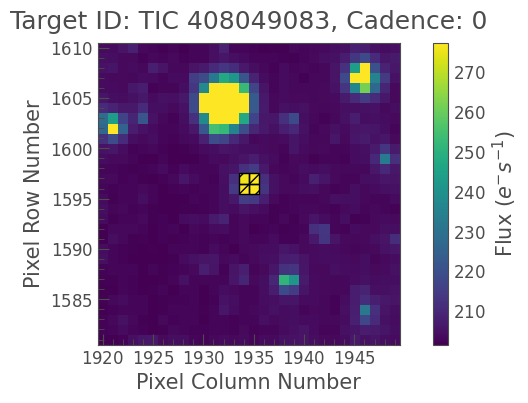

In [106]:
tpf.plot(aperture_mask=target_mask, mask_color='k');


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

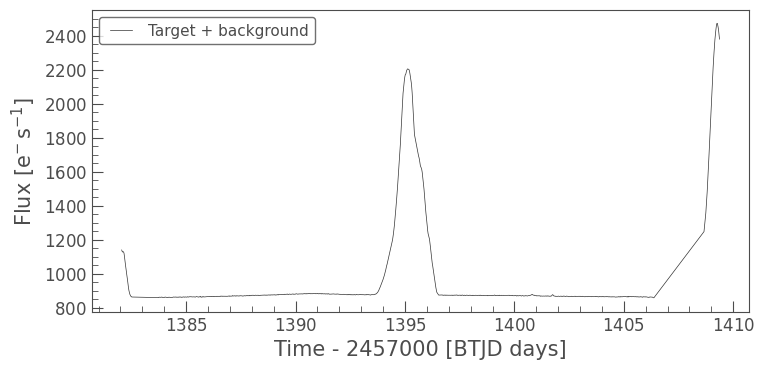

In [107]:
target_lc = tpf.to_lightcurve(aperture_mask=target_mask)
target_lc.plot(label='Target + background')

451

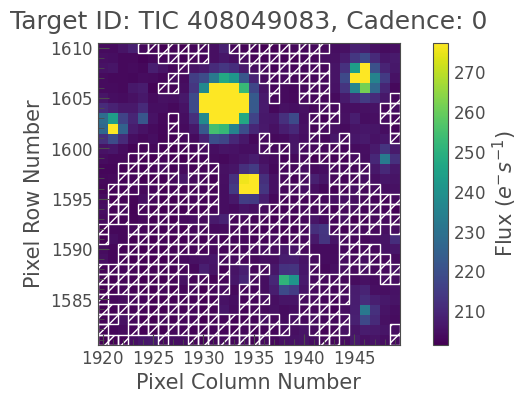

In [108]:
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
n_background_pixels

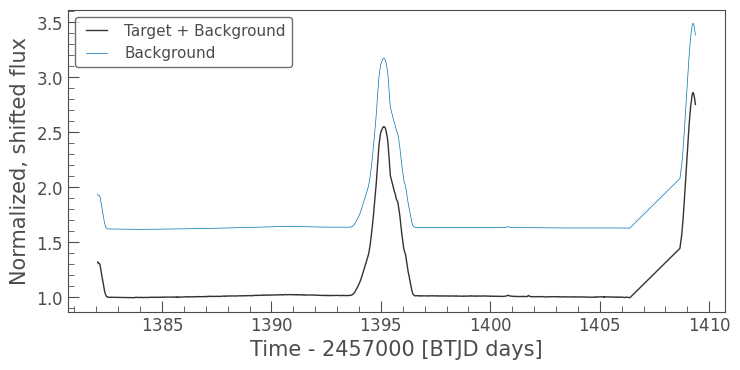

In [111]:
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
background_estimate_lc = background_lc_per_pixel * n_target_pixels
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');
corrected_lc = target_lc - background_estimate_lc.flux


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

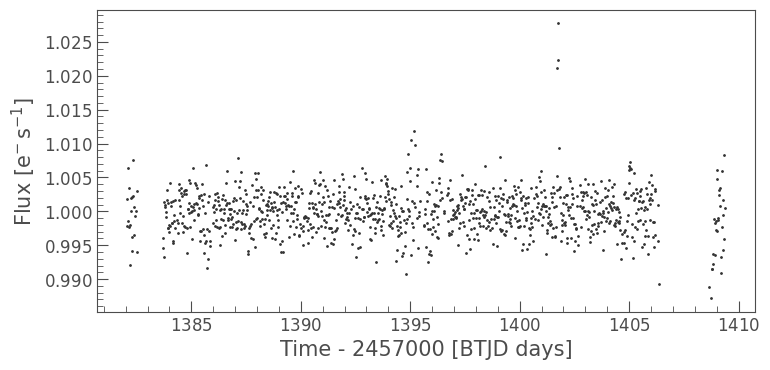

In [112]:
corrected_lc.flatten(101).scatter()